# 自编码器

自编码器是一种对称式的网络结构，分为**编码器和解码器**，现在通常用于表征学习和降维，优化目标是最小化输入、输出的差别，训练所得中间层为所需要学的表征。

自编码器的思想是通过无监督学习学习数据中的潜在模式，输入层是输出层数量应该保持一致。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
def allow_gpu_memory_growth(log_device_placement=True):
    """
    Allow dynamic memory growth (by default, tensorflow allocates all gpu memory).
    This sometimes fixes the 
    <<Error : Failed to get convolution algorithm. 
    This is probably because cuDNN failed to initialize, 
    so try looking to see if a warning log message was printed above>>. 
    May hurt performance slightly (see https://www.tensorflow.org/guide/gpu).

    Usage: Run before any other code.

    :param log_device_placement: set True to log device placement (on which device the operation ran)
    :return:None
    """
    from tensorflow.compat.v1.keras.backend import set_session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
    config.log_device_placement = log_device_placement
    sess = tf.compat.v1.Session(config=config)
    set_session(sess)
allow_gpu_memory_growth()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:3b:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: GeForce RTX 2080, pci bus id: 0000:d9:00.0, compute capability: 7.5



In [2]:
np.random.seed(42)
tf.random.set_seed(42)

import os
IMGS_PATH = os.path.join('.', 'imgs', 'autoencoder')
os.makedirs(IMGS_PATH, exist_ok=True)

In [3]:
def save_fig(fig_id, fig_extension='png', tight_layout=True, resolusion=300):
    path = os.path.join(IMGS_PATH, fig_id + '.' + fig_extension)
    print('Saving fig', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolusion)

In [4]:
%matplotlib inline

# 1. 线性自编码器实现PCA

当自编码器只采用线性激活函数并且损失函数是MSE时，实际上实现的是PCA。

构建三维数据用于测试。

In [5]:
np.random.seed(4)

In [6]:
def generate_data(m, w1=0.1, w2=0.2, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi/2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_data(100)
X_train = X_train - X_train.mean(axis=0, keepdims=True)

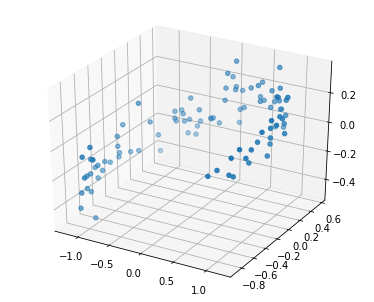

In [7]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(5,4))
ax = Axes3D(fig)
ax.scatter(X_train[:,0], X_train[:,1], X_train[:,2] , cmap=cm.viridis)

In [8]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
# keras中，模型能作为另一个模型中的一层来使用
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.1))

In [9]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
4/4 [==============================] - 0s 3ms/step - loss: 0.2724
Epoch 2/20
4/4 [==============================] - 0s 2ms/step - loss: 0.2467
Epoch 3/20
4/4 [==============================] - 0s 2ms/step - loss: 0.2181
Epoch 4/20
4/4 [==============================] - 0s 2ms/step - loss: 0.1952
Epoch 5/20
4/4 [==============================] - 0s 2ms/step - loss: 0.1721
Epoch 6/20
4/4 [==============================] - 0s 2ms/step - loss: 0.1498
Epoch 7/20
4/4 [==============================] - 0s 2ms/step - loss: 0.1305
Epoch 8/20
4/4 [==============================] - 0s 2ms/step - loss: 0.1116
Epoch 9/20
4/4 [==============================] - 0s 2ms/step - loss: 0.0985
Epoch 10/20
4/4 [==============================] - 0s 2ms/step - loss: 0.0872
Epoch 11/20
4/4 [==============================] - 0s 3ms/step - loss: 0.0778
Epoch 12/20
4/4 [==============================] - 0s 2ms/step - loss: 0.0714
Epoch 13/20
4/4 [==============================] - 0s 2ms/step - loss: 0.

In [10]:
codings = encoder.predict(X_train)

In [11]:
X_train.shape, codings.shape

((100, 3), (100, 2))

Saving fig linear_autoencoder_pca_plot


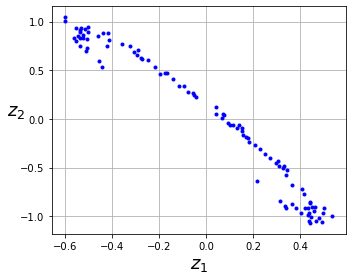

In [12]:
plt.figure(figsize=(5,4))
plt.plot(codings[:, 1], codings[:, 0], 'b.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.grid(True)
save_fig('linear_autoencoder_pca_plot')

# 2. 堆叠式自编码器

即编码器和解码器都含有多层，称为堆叠式自编码器或深度自编码器，随着层数增加，能够学到更多复杂的编码模式。

数据：Fashion MNIST

## 2.1 数据导入与处理

图片数据为0-255 uint8格式。

In [13]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [14]:
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train[:-5000], X_train[-5000:]
y_train, y_valid = y_train[:-5000], y_train[-5000:]
print('X_train shape:', X_train.shape)
print('X_Valid shape:', X_valid.shape)
print('X_test shape:', X_test.shape)

X_train shape: (55000, 28, 28)
X_Valid shape: (5000, 28, 28)
X_test shape: (10000, 28, 28)


## 2.2 模型构建和训练

编码器和解码器都有三层

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu'),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

In [16]:
stacked_encoder.summary()
stacked_decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
____________________________

In [17]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [18]:
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3164 - val_rounded_accuracy: 0.9006
Epoch 2/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9197
Epoch 3/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2986 - val_rounded_accuracy: 0.9198
Epoch 4/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9286
Epoch 6/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2914 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

## 2.3 数据重建

通过重建数据，检查模型学习效果

In [19]:
def show_reconstructions(model, imgs=X_valid, n_imgs=10, cmap=None):
    reconstructions = model.predict(imgs[:n_imgs])
    fig = plt.figure(figsize=(n_imgs * 1.5, 3))
    for i in range(n_imgs):
        plt.subplot(2, n_imgs, 1+i)
        plt.imshow(imgs[i], cmap=cmap)
        plt.axis('off')
        plt.subplot(2, n_imgs, 1+i+n_imgs)
        plt.imshow(reconstructions[i], cmap=cmap)
        plt.axis('off')

Saving fig reconstruction_plot


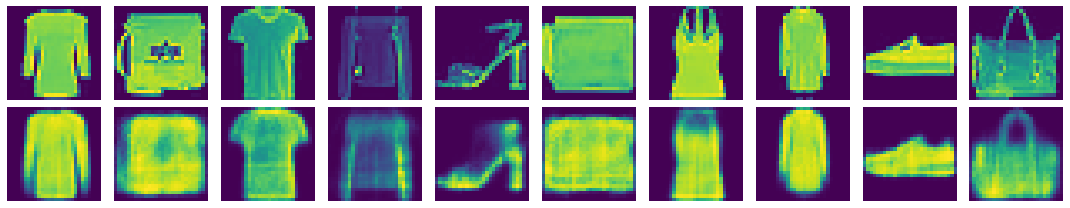

In [20]:
show_reconstructions(stacked_ae)
save_fig('reconstruction_plot')

## 2.4 可视化

通过TSNE降维将Fashion MNIST数据进行可视化

In [21]:
from sklearn.manifold import TSNE
import matplotlib as mpl

In [22]:
X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
# scaleing
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

In [23]:
X_valid_2D.shape

(5000, 2)

(-0.05, 1.05, 0.04404635913670063, 0.9386361744254827)

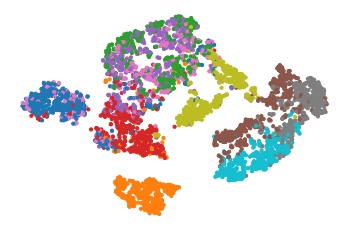

In [24]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap='tab10')
plt.axis('off')

Saving fig fashion_mnist_visualization_plot


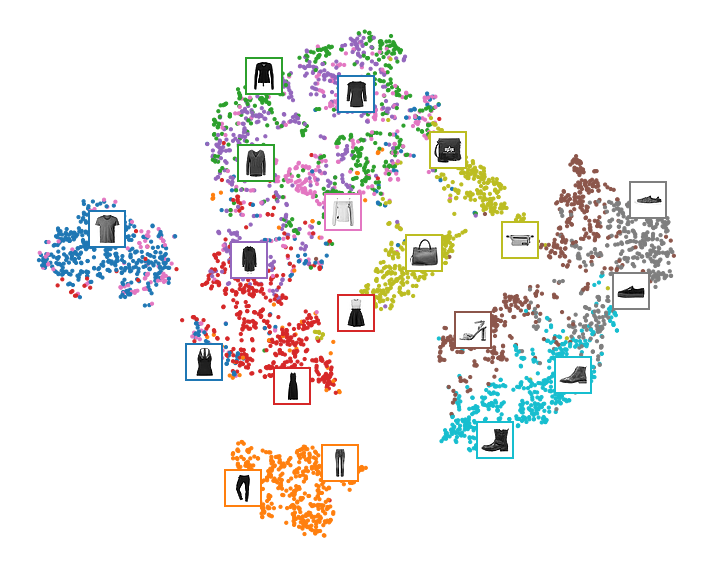

In [25]:
plt.figure(figsize=(10,8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, cmap=cmap, s=10)
img_position = np.array([[1.0, 1.0]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - img_position) ** 2, axis=1)
    if np.min(dist) > 0.02: # 相互之间足够远，图的横纵坐标都是介于0-1
        img_position = np.r_[img_position, [position]]
        img_box = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap='binary'),
            position, bboxprops={'edgecolor':cmap(y_valid[index]), 'lw': 2})
        plt.gca().add_artist(img_box)
plt.axis('off')
save_fig('fashion_mnist_visualization_plot')

# 3. 自编码器的训练

自编码器除了可以用于降维，另外也可以用于非监督的预训练。当监督式任务比较重而有标签的数据并不多时，可以通过神经网络处理相似的任务，然后复用部分层。

对于自编码器的训练，有一些其它的技巧

## 权重绑定

为了避免过拟合，可以将编码器和解码器对应层权重设为相同（在实际代码中互为转置）,而偏置层则独立设置。

In [26]:
# 自定义权重相同但为转置的Dense层
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name='bias',
                                     shape=[self.dense.input_shape[-1]],
                                     initializer='zeros')
        super().build(batch_input_shape)
    
    def call(self, inputs):
        # 将相乘的后一个矩阵转置
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [27]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense1 = keras.layers.Dense(100, activation='selu')
dense2 = keras.layers.Dense(30, activation='selu')

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense1,
    dense2
])
tied_decoder = keras.models.Sequential([
    DenseTranspose(dense2, activation='selu'),
    DenseTranspose(dense1, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.5),
               metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
# validation_data需要使用元组，列表会出错

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3082 - val_rounded_accuracy: 0.9077
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2951 - val_rounded_accuracy: 0.9284
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3022 - val_rounded_accuracy: 0.9078
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2889 - rounded_accuracy: 0.9302 - val_loss: 0.2880 - val_rounded_accuracy: 0.9333
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2865 - rounded_accuracy: 0.9325 - val_loss: 0.2873 - val_rounded_accuracy: 0.9316
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2861 - val_rounded_accuracy: 0.9353
Epoch 7/10
1719/1719 [==================

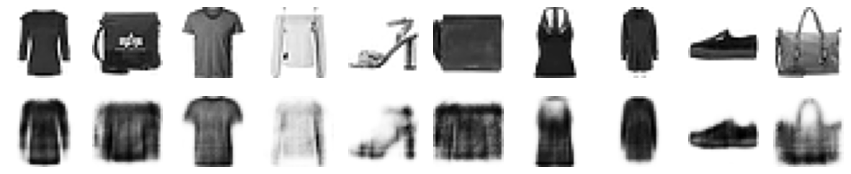

In [28]:
show_reconstructions(tied_ae, cmap='binary')
plt.show()

# 4. 卷积自编码器

对于图像数据，经验可知更适合通过卷积操作来进行处理，对于处理图像数据的自编码器也是如此，可以将自编码器中的Dense层换为卷积层。不过使用卷积层之后，要使用权重绑定训练的话解码器的操作会比Dense自编码器稍微复杂一些、

In [29]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [30]:
tf.random.set_seed(42)
np.random.seed(42)

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2844 - val_rounded_accuracy: 0.9297
Epoch 2/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2756 - rounded_accuracy: 0.9414 - val_loss: 0.2729 - val_rounded_accuracy: 0.9455
Epoch 3/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2708 - rounded_accuracy: 0.9462 - val_loss: 0.2696 - val_rounded_accuracy: 0.9497
Epoch 4/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2682 - rounded_accuracy: 0.9491 - val_loss: 0.2686 - val_rounded_accuracy: 0.9491
Epoch 5/5
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2664 - rounded_accuracy: 0.9510 - val_loss: 0.2671 - val_rounded_accuracy: 0.9510


In [31]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)         

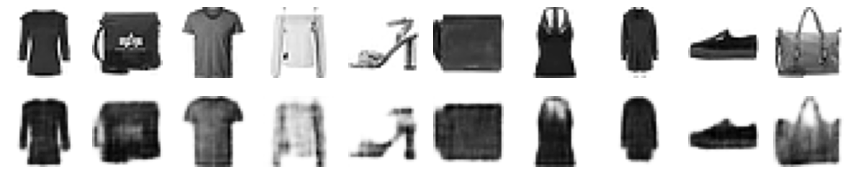

In [32]:
show_reconstructions(conv_ae, cmap='binary')
plt.show()

# 5. 循环自编码器

In [33]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [34]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 36s 21ms/step - loss: 0.5192 - rounded_accuracy: 0.7492 - val_loss: 0.4581 - val_rounded_accuracy: 0.8081
Epoch 2/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.4051 - rounded_accuracy: 0.8432 - val_loss: 0.3743 - val_rounded_accuracy: 0.8680
Epoch 3/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.3653 - rounded_accuracy: 0.8710 - val_loss: 0.3602 - val_rounded_accuracy: 0.8769
Epoch 4/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.3508 - rounded_accuracy: 0.8808 - val_loss: 0.3523 - val_rounded_accuracy: 0.8773
Epoch 5/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.3405 - rounded_accuracy: 0.8875 - val_loss: 0.3362 - val_rounded_accuracy: 0.8925
Epoch 6/10
1719/1719 [==============================] - 35s 20ms/step - loss: 0.3334 - rounded_accuracy: 0.8923 - val_loss: 0.3307 - val_rounded_accuracy: 0.8960
Epoch 7/10
1719/1719 [======

In [35]:
recurrent_encoder.summary()
recurrent_decoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 28, 100)           51600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                15720     
Total params: 67,320
Trainable params: 67,320
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector (RepeatVector) (None, 28, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 28, 100)           52400     
_________________________________________________________________
time_distributed (TimeDistri (None, 28, 28)            2828      
Total params: 55,228
Trainab

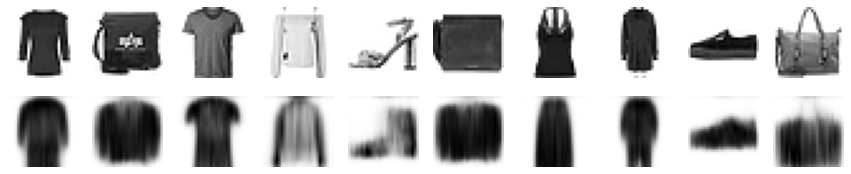

In [36]:
show_reconstructions(recurrent_ae, cmap='binary')
plt.show()

# 6. 降噪自编码器

为了提高模型健壮性，学到有用的特征，有另一个版本，降噪自编码器，数据在输入前加入噪声，比如高斯噪声、Dropout

In [37]:
# 使用高斯噪声
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1),
                    metrics=[rounded_accuracy])

In [41]:
history = denoising_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3499 - rounded_accuracy: 0.8774 - val_loss: 0.3173 - val_rounded_accuracy: 0.9053
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3122 - rounded_accuracy: 0.9095 - val_loss: 0.3086 - val_rounded_accuracy: 0.9122
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3063 - rounded_accuracy: 0.9146 - val_loss: 0.3043 - val_rounded_accuracy: 0.9182
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3028 - rounded_accuracy: 0.9177 - val_loss: 0.3002 - val_rounded_accuracy: 0.9217
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2998 - rounded_accuracy: 0.9203 - val_loss: 0.2976 - val_rounded_accuracy: 0.9238
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2977 - rounded_accuracy: 0.9222 - val_loss: 0.2955 - val_rounded_accuracy: 0.9265
Epoch 7/10
1719/1719 [==================

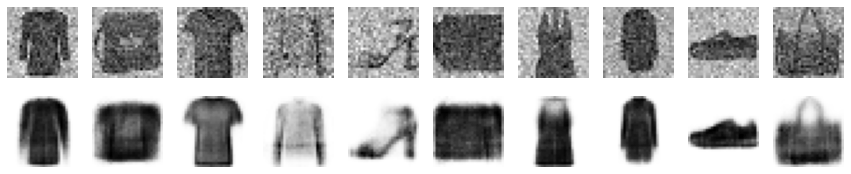

In [44]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True), cmap='binary')

In [46]:
# 使用Dropout
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='selu')
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.0),
                  metrics=[rounded_accuracy])

In [47]:
dropout_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3125 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9173
Epoch 7/10
1719/1719 [==================

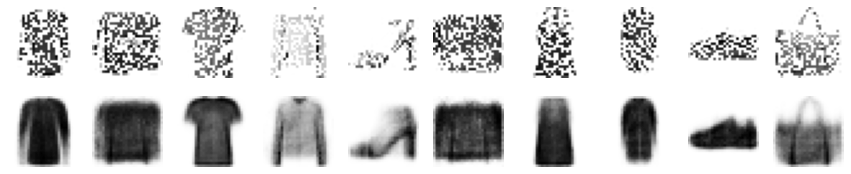

In [50]:
dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True), cmap='binary')

# 7. 稀疏自编码器

另外一个能产生较好特征抽取表现的约束是增加**稀疏性**。通过在代价函数中加入适当的项，迫使自动编码器减少编码层中活跃神经元的数量，例如**编码层输出采用sigmoid作为激活函数、增加向量维数、使用L1正则化、KL散度**。

对于两个分布$P, Q$，KL散度是$D_{KL}(P\Vert Q)$，有下式计算：
$$
D_{KL}(P\Vert Q) = \sum_i P(i) \log \frac{P(i)}{Q(i)}
$$

## 7.1 普通自编码器

首先构建一个普通自编编码器作为基准，训练结束后将验证集输入到**编码器**以获取向量表示，然后将向量表示和各输出层（编码器输出层，例如下面的自编码器中是30）输出向量均值进行可视化，以展示其**向量表示的稀疏性**。

In [51]:
# 普通自编码器
simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4274 - rounded_accuracy: 0.8010 - val_loss: 0.3748 - val_rounded_accuracy: 0.8525
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3574 - rounded_accuracy: 0.8711 - val_loss: 0.3469 - val_rounded_accuracy: 0.8840
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3359 - rounded_accuracy: 0.8901 - val_loss: 0.3308 - val_rounded_accuracy: 0.8942
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3239 - rounded_accuracy: 0.8995 - val_loss: 0.3228 - val_rounded_accuracy: 0.8993
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3185 - rounded_accuracy: 0.9033 - val_loss: 0.3186 - val_rounded_accuracy: 0.9048
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3149 - rounded_accuracy: 0.9064 - val_loss: 0.3152 - val_rounded_accuracy: 0.9064
Epoch 7/10
1719/1719 [==================

In [148]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    width = bins[1:] - bins[:-1]
    x = bins[:-1] + width / 2
    ax.bar(x, counts/len(data), width=width*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda y, position: "{}%".format(int(100*y))))
    
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins+1)
    
    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], 'k--', label='MEAN={:.2f}'.format(mean))
    ax1.legend()
    ax1.set_xlabel('Activation')
    ax1.set_ylabel('% Activations')
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], 'k--')
    ax2.set_xlabel('Neural Mean Activation')
    ax2.set_ylabel('% Neurons')
    ax2.axis([0, 1, 0, height])

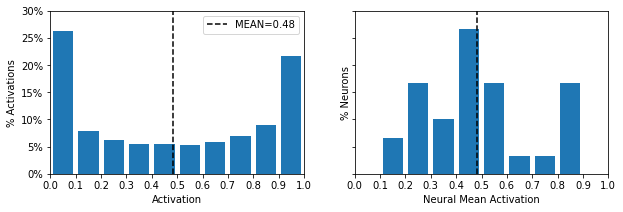

In [151]:
plot_activations_histogram(simple_encoder, height=0.3)

## 7.2 L1约束的自编码器

为了控制变量，保持编码器输出层维数（30），可以观察输出向量稀疏性大大增强，如果增加维数至更大例如300，会更加稀疏。

In [167]:
# 编码器加入L1正则化
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='sigmoid'),
    keras.layers.ActivityRegularization(l1=1e-3)
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.0),
                    metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4340 - rounded_accuracy: 0.8038 - val_loss: 0.3776 - val_rounded_accuracy: 0.8594
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3616 - rounded_accuracy: 0.8747 - val_loss: 0.3525 - val_rounded_accuracy: 0.8850
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3432 - rounded_accuracy: 0.8897 - val_loss: 0.3398 - val_rounded_accuracy: 0.8943
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3330 - rounded_accuracy: 0.8978 - val_loss: 0.3310 - val_rounded_accuracy: 0.9013
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3265 - rounded_accuracy: 0.9027 - val_loss: 0.3261 - val_rounded_accuracy: 0.9041
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3227 - rounded_accuracy: 0.9053 - val_loss: 0.3230 - val_rounded_accuracy: 0.9070
Epoch 7/10
1719/1719 [==================

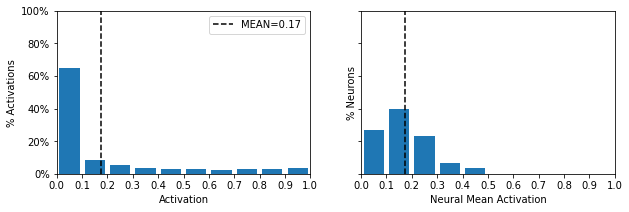

In [168]:
plot_activations_histogram(sparse_l1_encoder, height=1)

## 7.3 加入KL散度的自编码器

In [171]:
K = keras.backend
kl_divergence = keras.losses.kl_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    
    def __call__(self, inputs):
        mean_activity = K.mean(inputs, axis=0)
        return self.weight * (kl_divergence(self.target, mean_activity) + 
                             kl_divergence(1. - self.target, 1. - mean_activity))

In [176]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(30, activation='sigmoid', activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, input_shape=[30], activation='selu'),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=1.0),
                    metrics=[rounded_accuracy])
sparse_kl_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4177 - rounded_accuracy: 0.8082 - val_loss: 0.3704 - val_rounded_accuracy: 0.8574
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3532 - rounded_accuracy: 0.8762 - val_loss: 0.3459 - val_rounded_accuracy: 0.8884
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3345 - rounded_accuracy: 0.8927 - val_loss: 0.3309 - val_rounded_accuracy: 0.8977
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3252 - rounded_accuracy: 0.8997 - val_loss: 0.3244 - val_rounded_accuracy: 0.9016
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3204 - rounded_accuracy: 0.9034 - val_loss: 0.3206 - val_rounded_accuracy: 0.9046
Epoch 6/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3171 - rounded_accuracy: 0.9061 - val_loss: 0.3175 - val_rounded_accuracy: 0.9070
Epoch 7/10
1719/1719 [============

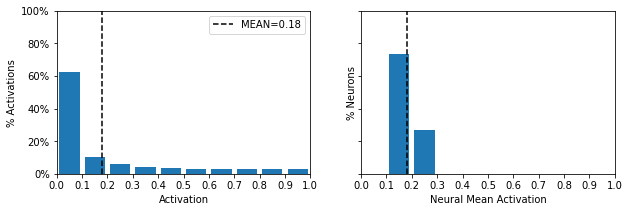

In [178]:
plot_activations_histogram(sparse_kl_encoder, height=1)

# 8. 变分自编码器（VAE）

**前面几类自编码器基本快退出历史舞台，现在提到自编码器主要有价值的事变分自编码器（VAE），在普通自编码器中引入了良好的统计学理念，属于生成式AE，最初于2013年被提出。**

编码层不再输出的是一组隐向量，而是均值、方差，将其视为正态分布，对正态分布进行采样后所得数据作为输入输入到解码层。

变分自编码器有良好的**隐层结构和连续性**

损失函数包括两部分：1. 正常AE的输入重建损失2. 隐空间的损失（目标分布和编码分布间的KL散度）。1使得VAE产生更类似输入的输出，2使得VAE的样本产生如同高斯分布。隐空间损失函数为：
$$
\mathcal L = -\frac{1}{2}\sum_{i=1}^K[1 + \log \sigma_i^2 - \sigma_i^2 - \mu_i^2]
$$

In [179]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean
    
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true),  tf.round(y_pred))

In [180]:
coding_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation='selu')(z)
z = keras.layers.Dense(100, activation='selu')(z)
codings_mean = keras.layers.Dense(coding_size)(z)
codings_log_var = keras.layers.Dense(coding_size)(z)
codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[coding_size])
x = keras.layers.Dense(100, activation=tf.nn.selu)(decoder_inputs)
x = keras.layers.Dense(150, activation=tf.nn.selu)(x)
x = keras.layers.Dense(28*28, activation=tf.nn.sigmoid)(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(
    inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * tf.reduce_sum(
    1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean), axis=-1)
variational_ae.add_loss(tf.reduce_mean(latent_loss) / 784.)
variational_ae.compile(loss='binary_crossentropy', optimizer='rmsprop', 
                      metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128, 
                            validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 4s 10ms/step - loss: 0.3893 - rounded_accuracy: 0.8611 - val_loss: 0.3585 - val_rounded_accuracy: 0.8900
Epoch 2/25
430/430 [==============================] - 4s 10ms/step - loss: 0.3434 - rounded_accuracy: 0.8975 - val_loss: 0.3376 - val_rounded_accuracy: 0.9049
Epoch 3/25
430/430 [==============================] - 4s 10ms/step - loss: 0.3329 - rounded_accuracy: 0.9054 - val_loss: 0.3296 - val_rounded_accuracy: 0.9107
Epoch 4/25
430/430 [==============================] - 4s 10ms/step - loss: 0.3276 - rounded_accuracy: 0.9095 - val_loss: 0.3281 - val_rounded_accuracy: 0.9112
Epoch 5/25
430/430 [==============================] - 4s 10ms/step - loss: 0.3247 - rounded_accuracy: 0.9119 - val_loss: 0.3249 - val_rounded_accuracy: 0.9120
Epoch 6/25
430/430 [==============================] - 4s 10ms/step - loss: 0.3226 - rounded_accuracy: 0.9136 - val_loss: 0.3242 - val_rounded_accuracy: 0.9116
Epoch 7/25
430/430 [==========================

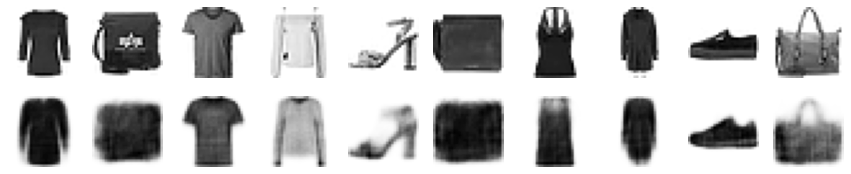

In [181]:
show_reconstructions(variational_ae, cmap='binary')

## 8.1 通过变分自编码器生成图片

Saving fig semantic_interpolation_plot


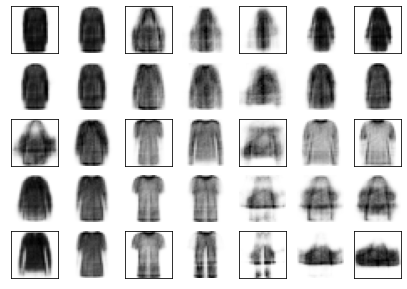

In [183]:
codings = tf.random.normal(shape=[12, coding_size])
codings_grid = tf.reshape(codings, [1, 3, 4, coding_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, coding_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

In [186]:
interpolated_codings

<tf.Tensor: shape=(35, 10), dtype=float32, numpy=
array([[-0.20192538,  1.2318321 , -1.4805176 , -1.6560574 ,  0.34140038,
        -1.0558523 ,  1.4286845 , -0.567554  ,  0.30566445,  0.2195522 ],
       [-0.4969151 ,  0.3517224 , -0.92263305, -0.6650314 ,  0.16383106,
        -0.42526442,  0.77369916, -0.5832965 ,  0.30131963,  0.30817816],
       [-0.9688986 , -1.0564531 , -0.03001779,  0.9206101 , -0.12027983,
         0.58367604, -0.27427718, -0.6084845 ,  0.29436794,  0.44997966],
       [-0.35092542,  0.11724158, -0.0836763 ,  1.1408633 ,  0.10615684,
         0.7521869 , -0.97941184, -0.6006965 , -0.09553835,  0.12225441],
       [ 0.18129306,  1.4969053 , -0.33658206,  1.0283048 ,  0.46666583,
         0.6967539 , -1.4683152 , -0.6086896 , -0.5003394 , -0.2234802 ],
       [-0.97672254,  1.7364883 , -1.037944  , -0.04854367,  1.2551327 ,
        -0.08585349, -0.7864458 , -0.7601262 , -0.6264498 , -0.22575505],
       [-1.700482  ,  1.8862276 , -1.476295  , -0.72157377,  1.74792